In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from tensorflow.keras.applications import ResNet152V2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from keras import Sequential
from keras import layers
from keras import losses
from keras import optimizers

from keras.applications import ResNet152V2
from keras import backend as K

from sklearn.metrics import confusion_matrix, accuracy_score

DATASET_DIR = 'MMU-Iris-Database'
SEED_NUMBER = 42
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# pd.np.random.seed(RANDOM_SEED)
# sklearn.utils.check_random_state(RANDOM_SEED)

# Utils

In [2]:
def plot_image(i, predictions_array, true_label, img, class_names):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(20,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation acc')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Carrega o dataset

In [3]:
train_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="training",
  seed=SEED_NUMBER,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

Found 225 files belonging to 45 classes.


Using 180 files for training.


In [4]:
val_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=SEED_NUMBER,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 225 files belonging to 45 classes.
Using 45 files for validation.


# Visualiza os dados

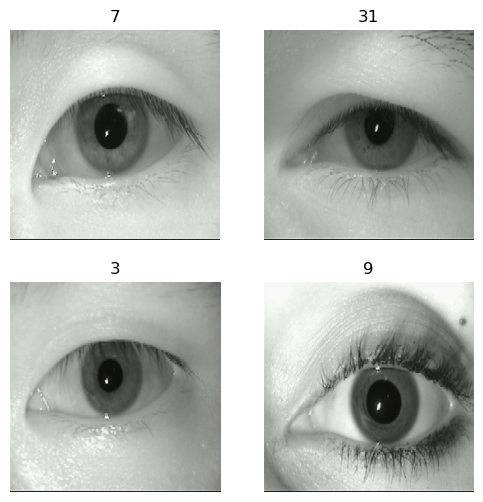

In [5]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Otimiza o dataset

Utiliza os métodos prefetch e cache para realizar o yield das imagens a partir do disco sem blockear as entradas e saídas do programa.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds: tf.data.Dataset = train_ds.cache().shuffle(25, SEED_NUMBER).prefetch(buffer_size=AUTOTUNE)
val_ds: tf.data.Dataset = val_ds.cache().shuffle(25, SEED_NUMBER).prefetch(buffer_size=AUTOTUNE)

# Criação do modelo

In [7]:
def build_model(summary):
  K.clear_session()
  
  LEARNING_RATE = 1e-3
  
  model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
  ])

  model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

  if summary:
    model.summary()
  
  return model

In [8]:
def run_training(train_ds, val_ds, model, plot=False, verbose=0):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=0.005, restore_best_weights=True)
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  
  if plot:
    plot_history(history)

Epoch 1/5


23/23 [==============================] - 2s 56ms/step - loss: 3.8895 - accuracy: 0.0222 - val_loss: 3.8083 - val_accuracy: 0.0222
Epoch 2/5
23/23 [==============================] - 1s 51ms/step - loss: 3.7893 - accuracy: 0.0667 - val_loss: 3.8550 - val_accuracy: 0.0222
Epoch 3/5
23/23 [==============================] - 1s 50ms/step - loss: 3.5327 - accuracy: 0.1222 - val_loss: 3.3888 - val_accuracy: 0.1778
Epoch 4/5
23/23 [==============================] - 1s 50ms/step - loss: 2.3183 - accuracy: 0.4222 - val_loss: 2.5216 - val_accuracy: 0.3556
Epoch 5/5
23/23 [==============================] - 1s 50ms/step - loss: 1.1578 - accuracy: 0.6944 - val_loss: 4.3651 - val_accuracy: 0.3333


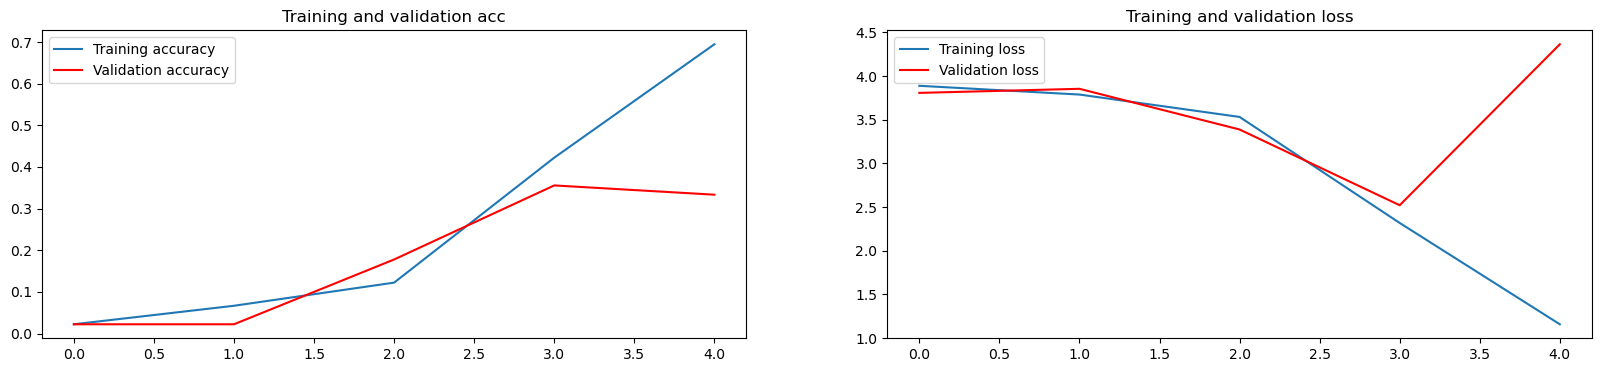

In [9]:
model = build_model(False)

run_training(train_ds, val_ds, model, True, 1)

In [22]:
y_pred = model.predict(val_ds).argmax(axis=0)
y_test = np.concatenate([y for x, y in val_ds], axis=0)
np.sort(y_test)

6/6 [==============================] - 0s 14ms/step


array([ 0,  2,  4,  4,  7,  9, 10, 10, 10, 11, 11, 12, 14, 14, 17, 17, 18,
       19, 20, 20, 21, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37,
       37, 37, 38, 39, 40, 41, 42, 42, 43, 44, 44], dtype=int32)

In [23]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
np.sort(y_train)

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
       25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28,
       29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33,
       33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37,
       37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41,
       42, 42, 42, 43, 43, 43, 43, 44, 44, 44], dtype=int32)

NameError: name 'predictions' is not defined

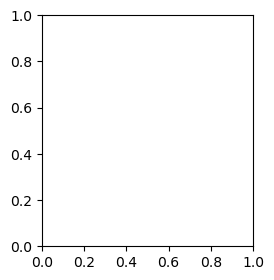

In [11]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], test_labels, test_images, class_names)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  test_labels)
plt.show()